# Assignment 2 - Object Detection | Semantic Segmentation

This notebook contains the required task for the second assignment of the Software for Advanced Machine Learning course. Read the task description and implement the empty code cells. Each section represents a stage along implementing your task [Semantic Segmantation], from loading and inspecting the dataset to testing a **pre-trained** model. The sections are to guide you but you do not have to follow that specific order. 

Copy this notebook to your drive (File -> Save a copy in Drive), edit it and upload the final ipynb file to [Canvas](https://canvas.elte.hu) or upload the link to the Colab notebook itself. If you have your own machine with Jupyter installed, you can work there as well.

**Note** Make sure the notebook is using GPU accelerataion in Edit -> Notebook settings, otherwise inference can be very slow.

## Rules and Comments
- From the list of datasets and tasks listed in canvas, each student was atributed **1 task and 1 dataset** to use within this assignment. Please confirm yours in the Canvas assignment's description. 
- The emphasis of this assignment is put in the way you use and compare the different models. The metrics you present are very important.
- As always, copying others' code will make you fail the homework automatically (and thus the course). 
- **Deadline is April 24**
- Make sure your code can be run from an empty state (use Runtime -> Run all in the menu after restarting the notebook)
- Feel free to add more code cells as needed. But don't put code into external Python files to ease the reviewing.
- Please add your name and Neptun ID below for easier identification.

**Name: Brandon Ooi Wei Cheng**  
**Neptun ID:LR2175** 

## Task description
Given your task (Semantic Segmentation or Object Detection), you have to test three (3) pretrained models on the test set of a given dataset, comparing the results between the models. For the comparison, you have to use at least three (3) metrics commonly used in your task.

For example, if student A is given Object Detection task and the Ballons v2 dataset, then his/her task is to choose 3 pretrained object detection models [R-CNN, YOLO, ...] and evaluate them on the Ballons v2 test set, comparing the results using 3 metrics [mAP, Recall, ...]. If a dataset does not have a testing set, then the student should split at least 10% of the training set to create the test set.

For running test/evaluation/inference on a pre-trained model, it is important to know what are the model requirements, so that the input is preprocessed accordingly.
Make sure to explore the data and **present detailed evaluation metrics**.

**Please answer the questions.**



## 0. Import libraries
Import all libraries/packages that you believe will help you fulfil the task, but **for the network only PyTorch can be used.**

In [1]:
import torch
import torchvision
from torchvision import datasets, models
from torch.utils.data import Subset, Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms as T
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable

import tensorflow as tf

from __future__ import print_function, absolute_import, division
from collections import namedtuple

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time
import os
import copy

from PIL import Image
import albumentations as A
import cv2
from tqdm.notebook import tqdm

#!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
#import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Dataset 
Load the dataset you were given. If your data does not have a test set, split a portion of your training set (at least 10%).
Explore the dataset by visualizing the images and annotations.


#### Loading the dataset
Show some images and annotations of your dataset

In [2]:
##Labels from the cityscapes dataset
## https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py#L85

#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

#dictionary to change id into category for model evaluation
id2catid = {}
for label in labels:
    ide = label.id
    id2catid[ide] = label.categoryId


Total Images:  200
Image Size (375, 1242, 3)
Mask Size (375, 1242)
(375, 1242, 3) uint8
(375, 1242) uint8


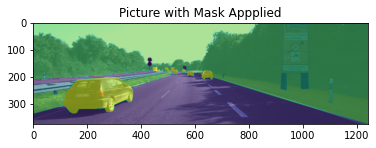

In [3]:
IMAGE_PATH = 'data_semantics/training/image_2/'
MASK_PATH = 'data_semantics/training/semantic/'

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)


img = Image.open(IMAGE_PATH + df['id'][100] + '.png')
mask = Image.open(MASK_PATH + df['id'][100] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)

imagearray = np.array(img)
maskarray = np.array(mask)
print(imagearray.shape, imagearray.dtype)
print(maskarray.shape, maskarray.dtype)

plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()


In [4]:
maskarray
np.unique(maskarray)

#transforming the ground truth to fit what the models will predict 
#human = 6 on cityscapes but 15 on pascal VOC
#car = 7 on cityscapes but 7 on pascal VOC
#only these 2 classes were detected from pretrained models, so we just use these 2 classes for evaluation.
def transform_mask(maskarray):
    newarray = np.zeros_like(maskarray)
    for i in range(len(maskarray)):
        for j in range(len(maskarray[1])):
            newarray[i][j] = id2catid[maskarray[i][j]]
            if newarray[i][j] == 6:
                newarray[i][j] = 15
            elif newarray[i][j] == 7:
                continue
    return newarray
            
new_maskarray = transform_mask(maskarray)
new_maskarray

array([[5, 5, 5, ..., 4, 4, 4],
       [5, 5, 5, ..., 4, 4, 4],
       [5, 5, 5, ..., 4, 4, 4],
       ...,
       [1, 1, 1, ..., 4, 4, 4],
       [1, 1, 1, ..., 4, 4, 4],
       [1, 1, 1, ..., 1, 4, 4]], dtype=uint8)

#### Pre-processing the dataset

In [5]:
mean = [0.485,0.456,0.406]
std = [0.229,0.224, 0.225]
trf = T.Compose([T.Resize(size = (375,1241)),
                 T.ToTensor(),
                 T.Normalize(mean = mean, std = std)])
inp = trf(img).unsqueeze(0)
print(inp.shape)

fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()
lraspp = torchvision.models.segmentation.lraspp_mobilenet_v3_large(pretrained=True).eval()
deeplab = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

torch.Size([1, 3, 375, 1241])


In [6]:
out = deeplab(inp)['out']
print(out.shape)

torch.Size([1, 21, 375, 1241])


In [7]:
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print(om.shape)
print(np.unique(om))

def predict_array(img, model):
    mean = [0.485,0.456,0.406]
    std = [0.229,0.224, 0.225]
    trf = T.Compose([T.Resize(size = (375,1242)),
                 T.ToTensor(),
                 T.Normalize(mean = mean, std = std)])
    inp = trf(img).unsqueeze(0)
    out = model(inp)['out']
    om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
    return om
om

(375, 1241)
[0 7]


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

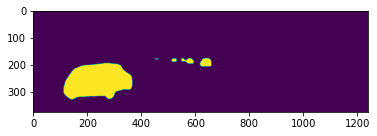

In [8]:
plt.imshow(om)
plt.show()

In [9]:
def decode_segmap(image, nc=21):
    
    label_colors = np.array([(0,0,0), #Background
                             (128,0,0),(0,128,0),(128,128,0), (0,0,128), (128,0,128),
                             (0, 128, 128), (128,128,128), (64,0,0), (192,0,0), (64,128,0),
                             (192,128,0), (64,0,128), (192,0,128), (64,128,128), (192,128,128),
                             (0,64,0),(128,64,0), (0,192,0), (128,192,0), (0,64,128)])
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    
    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l,0]
        g[idx] = label_colors[l,1]
        b[idx] = label_colors[l,2]
    
    rgb = np.stack([r,g,b], axis = 2)
    return rgb

(375, 1241, 3)


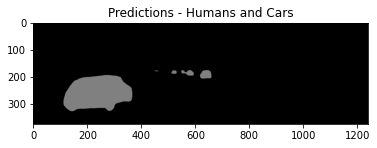

In [10]:
rgb = decode_segmap(om)
print(rgb.shape)
plt.title('Predictions - Humans and Cars')
plt.imshow(rgb); plt.show()

(375, 1242, 3)


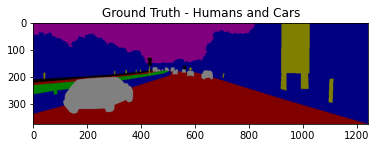

In [11]:
rgb = decode_segmap(new_maskarray)
print(rgb.shape)
plt.title('Ground Truth - Humans and Cars')
plt.imshow(rgb); plt.show()

## 2. Models
Load the 3 chosen models for your given task. Show the model's architecture.

In [12]:
fcn

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [13]:
lraspp

LRASPP(
  (backbone): IntermediateLayerGetter(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [14]:
deeplab

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

### Question 1
Describe the main differences between the models you chose.

FCN, LRASPP and DeepLabV3 are all improved Fully Convolutional Networks.
FCN is a fully convolutional network trained on the Coco dataset. There are skip connections from the earlier layers which are utilized to reconstruct accurate segmentation boundaries by learning back relevant features, which are lost during downsampling.

LRASPP stands for Lite Reduced Atrous Spatial Pyramid Pooling. It is a segmentation decoder architecture built on MobileNetV3. It is lightweight and low on processing power and allows faster processing of images compared with the other 2.

DeepLabV3 is heavier duty compared with the LRASPP and FCN. It uses similar tools like Atrous convolutions, which helps in getting an understanding of large context using the same number of parameters. Also, Atrous Spatial Pyramidal Pooling to capture multi-scale information with a single input image.
It also uses Conditional Random Fields to try and classify not only the pixel by its own class but also by other classes to attain sharper boundaries of the results.

In [15]:
# ADD YOUR CODE HERE

## 3. Evaluation
This is the most important part. Please give a detailed comparison between the models.

**Implement your metrics manually**. Do not use pre defined Pytorch metrics.

Calculate the metrics for each model on the test set.

Plot the metrics.

Show some predictions in comparison to the ground truth.

In [16]:
#pixel accuracy
def pixel_accuracy(output, mask):
    with torch.no_grad():
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [17]:
#MIoU
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=3):
    with torch.no_grad():
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [18]:
def dice_coef(pred_mask, mask, smooth=1e-10, n_classes=3):
    with torch.no_grad():
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        dice_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                dice_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = true_class.sum().float().item() + true_label.sum().float().item()

                dice = (2.0*(intersect) + smooth) / (union +smooth)
                dice_per_class.append(dice)
        return np.nanmean(dice_per_class)

#### Evaluate your models

In [19]:
X_train, X_test = train_test_split(df['id'].values, test_size=0.15, random_state=19)

class KittiDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None, mask_resize = (375,1241)):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.resize(cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE), (1241,375))
        mask = transform_mask(mask)
        if self.transform is not None:

            img = self.transform(Image.fromarray(img))
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).float()
            
        return img, mask

    
print('Train Size   : ', len(X_train))

print('Test Size    : ', len(X_test))

Train Size   :  170
Test Size    :  30


In [20]:
train_set = KittiDataset(IMAGE_PATH, MASK_PATH, X_train, trf)
test_set = KittiDataset(IMAGE_PATH, MASK_PATH, X_test, trf)

train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
test_loader = DataLoader(test_set, batch_size=4, shuffle=True)

In [21]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):

    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        
        out = model(image)['out']
        output = (torch.argmax(out.squeeze(), dim=0).detach().cpu()).float()
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):

    model.to(device); image=image.to(device)
    mask = mask.to(device)

    with torch.no_grad():
        image = image.unsqueeze(0)
        out = model(image)['out']
        output = (torch.argmax(out.squeeze(), dim=0).detach().cpu()).float()
 
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

def predict_image_mask_dice(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):

    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)

        
        out = model(image)['out']
        output = (torch.argmax(out.squeeze(), dim=0).detach().cpu()).float()
        dice = dice_coef(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, dice

In [22]:
image, mask = test_set[3]
print(predict_image_mask_dice(fcn, image, mask)[1])

0.049104346736818315


#### Show the metrics results

In [23]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy


def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

def dice_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_dice(model, img, mask)
        accuracy.append(acc)
    return accuracy


#### Show some predictions

In [24]:
fcn_mob_acc = pixel_acc(fcn, test_set)
lraspp_mob_acc = pixel_acc(lraspp, test_set)
deeplab_mob_acc = pixel_acc(deeplab, test_set)


In [25]:
fcn_mob_miou = miou_score(fcn, test_set)
lraspp_mob_miou = miou_score(lraspp, test_set)
deeplab_mob_miou = miou_score(deeplab, test_set)

In [26]:
fcn_mob_dice = dice_acc(fcn, test_set)
lraspp_mob_dice = dice_acc(lraspp, test_set)
deeplab_mob_dice = dice_acc(deeplab, test_set)

In [28]:
print('FCN Pixel Acc: %f %%' % ( np.mean(fcn_mob_acc)*100))
print('FCN MIoU Acc: %f %%' % (np.mean(fcn_mob_miou)*100))
print('FCN Dice Acc: %f %%' % (np.mean(fcn_mob_dice)*100))
print('LRASPP Pixel Acc: %f %%' % (np.mean(lraspp_mob_acc)*100))
print('LRASPP MIoU Acc: %f %%' % (np.mean(lraspp_mob_miou)*100))
print('LRASPP Dice Acc: %f %%' %( np.mean(lraspp_mob_dice)*100))
print('DeepLabV3 Pixel Acc: %f %%' % (np.mean(deeplab_mob_acc)*100))
print('DeepLabV3 MIoU Acc: %f %%' % (np.mean(deeplab_mob_miou)*100))
print('DeepLabV3 Dice Acc: %f %%' % (np.mean(deeplab_mob_dice)*100))


FCN Pixel Acc: 7.387533 %
FCN MIoU Acc: 0.724169 %
FCN Dice Acc: 1.384959 %
LRASPP Pixel Acc: 7.116906 %
LRASPP MIoU Acc: 0.713571 %
LRASPP Dice Acc: 1.366162 %
DeepLabV3 Pixel Acc: 7.408384 %
DeepLabV3 MIoU Acc: 0.729181 %
DeepLabV3 Dice Acc: 1.394360 %


## 4. Conclusion

### Answer the questions
#### Question 2. 
Which model performed the best? Why do you think it performed better than others?



#### Question 3. 
How could you improve the performance of the models?

2. DeepLabV3 definitely performed the best in all metrics. It is an upgrade over the FCN and the LRASPP. This is a more complex model which uses many techniques like Spatial pyramid pooling, Atrious Convolutions and depthwise convolutions as well as Conditional Random Fields to develop a deep understanding of the requirements for each class in each picture. This is also a more intensive model with regards to the processing power, so understandably, it should perform better.

3. I think firstly, training it on the dataset with cityscapes and a portion of the kitti dataset would allow it to perform better as the models were mostly trained on Coco with the classes belonging to the Pascal VOC classes. This would allow the models to detect a greater number of classes and hopefully, it would be much closer to the ground truth.